# SIREN 실습자료

8월 21일 AI Expert 과정을 위해 제작된 colab입니다.
본 자료에서는 SIREN MLP의 특성 및 활용에 대해 탐구합니다. SIREN MLP에 관한 이론적 배경은 다음 논문을 참고해주세요. [Implicit Neural Activations with Periodic Activation Functions](https://vsitzmann.github.io/siren).

본 실습은 다음의 순서로 구성되어 있습니다.
* Fitting an image
* Solving Poisson's equation
* Fitting SDF from Point Clouds

**본 코랩 파일을 본인 계정의 구글 드라이브에 저장하시면 수정 후 저장이 가능합니다: 메뉴바의 File --> Save a copy in Drive**

**GPU를 활성화하였는지 확인해주세요: 메뉴바의 Edit --> Notebook Setting --> T4 GPU 선택**

In [1]:
# 서버 연결 테스트
print("hello world!")

hello world!


In [2]:
# GPU 연결 테스트
import torch
print(torch.cuda.is_available())

True


# 0. 기본함수 정의

#### 필요한 패키지 설치 및 라이브러리 로드

In [3]:
!pip install plyfile

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import scipy
import skimage
import matplotlib.pyplot as plt
import logging
import plyfile
import skimage.measure

import time

좌표 grid를 생성하기 위한 함수를 정의합니다.

In [17]:
def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

differential operation을 수행하는 함수를 정의합니다. laplace, divergence, 그리고 gradient를 포함하며 이들은 pytorch의 autodiff를 통해 numerical하게 계산됩니다.


In [18]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)

def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div

def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

마지막으로, sine layer를 정의하고 이를 이용해 SIREN network를 구현합니다.

In [19]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate

class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

<a id='section_1'></a>
## 1. Fitting an image

본 section에서는 SIREN 함수 $\Phi(x)$로 grayscale image $f(x)$를 parametrize합니다. 이 때, $x$는 pixel coordinate을 의미합니다.

이를 위해 다음의 손실함수로 $\Phi$를 최적화합니다:
$$L=\int_{\Omega} \lVert \Phi(\mathbf{x}) - f(\mathbf{x}) \rVert\mathrm{d}\mathbf{x},$$ 이 때, $\Omega$는 이미지의 도메인을 의미합니다.

#### Define a pytorch dataset for fitting an image
cameraman image(scikit-image library에서 제공하는 예시 이미지)에서 각 픽셀의 좌표와 그에 해당하는 grayscale color의 pair를 return하는 pytorch dataset을 정의합니다.

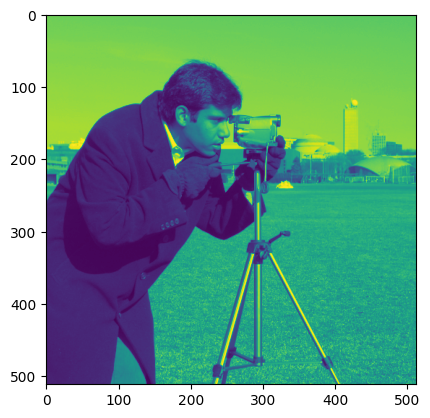

In [8]:
plt.imshow(skimage.data.camera())

In [9]:
def get_cameraman_tensor(sidelength):
    img = Image.fromarray(skimage.data.camera())
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

class ImageFitting(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        img = get_cameraman_tensor(sidelength)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0: raise IndexError

        return self.coords, self.pixels

#### Instantiate a dataset and a SIREN model

In [10]:
cameraman = ImageFitting(256)
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=1, hidden_features=256,
                  hidden_layers=3, outermost_linear=True)
img_siren.cuda()

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

#### Train the model

In [ ]:
total_steps = 500 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    model_output, coords = img_siren(model_input)
    loss = ((model_output - ground_truth)**2).mean()

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        img_grad = gradient(model_output, coords)
        img_laplacian = laplace(model_output, coords)

        fig, axes = plt.subplots(1,3, figsize=(18,6))
        axes[0].imshow(model_output.cpu().view(256,256).detach().numpy())
        axes[1].imshow(img_grad.norm(dim=-1).cpu().view(256,256).detach().numpy())
        axes[2].imshow(img_laplacian.cpu().view(256,256).detach().numpy())
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()

### Quiz 1: Comparision to the baseline model
- ReLU를 activation으로 활용하는 baseline 모델을 구현하세요.
- 구현된 Baseline 모델을 학습시키고 그 결과를 SIREN과 비교해보세요.
- Initialization은 pytorch 기본 initialization을 사용합니다. (SIREN처럼 명시적으로 initialize시킬 필요가 없습니다.)

In [13]:
class ReLULayer(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False):
        super().__init__()
        self.is_first = is_first

        self.in_features = in_features

        ######## Implement from here ########
        self.linear = nn.Linear(in_features, out_features, bias = bias)
        self.relu = torch.nn.ReLU()
        ####### End of Implementation #######

    def forward(self, input):
        return self.relu(self.linear(input))

class ReLUBaseline(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False):
        super().__init__()

        self.net = []

        ######## Implement from here ########

        self.net.append(ReLULayer(in_features, hidden_features,
                                  is_first=True))

        for i in range(hidden_layers):
            self.net.append(ReLULayer(hidden_features, hidden_features,
                                      is_first=False))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            self.net.append(final_linear)
        else:
            self.net.append(ReLULayer(hidden_features, out_features,
                                      is_first=False))

        ####### End of Implementation #######

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

### Instantiate dataset and the baseline model
cameraman = ImageFitting(256)
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

relu_baseline = ReLUBaseline(in_features=2, out_features=1, hidden_features=256,
                        hidden_layers=3, outermost_linear=True)
relu_baseline.cuda()

### Training loop
total_steps = 500 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-4, params=relu_baseline.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    model_output, coords = relu_baseline(model_input)
    loss = ((model_output - ground_truth)**2).mean()

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        img_grad = gradient(model_output, coords)
        img_laplacian = laplace(model_output, coords)

        fig, axes = plt.subplots(1,3, figsize=(18,6))
        axes[0].imshow(model_output.cpu().view(256,256).detach().numpy())
        axes[1].imshow(img_grad.norm(dim=-1).cpu().view(256,256).detach().numpy())
        axes[2].imshow(img_laplacian.cpu().view(256,256).detach().numpy())
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()

Output hidden; open in https://colab.research.google.com to view.

<a id='section_3'></a>
## 2. Solving Poisson's equation

본 섹션에서는 이미지의 gradient 정보만 주어졌을 때 원본 이미지를 복원하는 방법에 대해서 다룹니다.

이를 위해 다음의 손실함수로 $\Phi$를 최적화합니다:
$$L=\int_{\Omega} \lVert \nabla\Phi(\mathbf{x}) - \nabla f(\mathbf{x}) \rVert\mathrm{d}\mathbf{x},$$ 이 때, $\Omega$는 이미지의 도메인을 의미합니다.

#### Define the loss function

In [14]:
def gradients_mse(model_output, coords, gt_gradients):
    # compute gradients on the model
    gradients = gradient(model_output, coords)
    # compare them with the ground-truth
    gradients_loss = torch.mean((gradients - gt_gradients).pow(2).sum(-1))
    return gradients_loss

#### Define a pytorch dataset for solving Possion equation
Section 1과 마찬가지로 cameraman image를 사용합니다. 아래의 데이터셋은 각 픽셀의 좌표와 그에 해당하는 grayscale color, gradient, 그리고 laplace를 return합니다.

In [15]:
import scipy.ndimage

class PoissonEqn(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        img = get_cameraman_tensor(sidelength)

        # Compute gradient and laplacian
        grads_x = scipy.ndimage.sobel(img.numpy(), axis=1).squeeze(0)[..., None]
        grads_y = scipy.ndimage.sobel(img.numpy(), axis=2).squeeze(0)[..., None]
        grads_x, grads_y = torch.from_numpy(grads_x), torch.from_numpy(grads_y)

        self.grads = torch.stack((grads_x, grads_y), dim=-1).view(-1, 2)
        self.laplace = scipy.ndimage.laplace(img.numpy()).squeeze(0)[..., None]
        self.laplace = torch.from_numpy(self.laplace)

        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.coords, {'pixels':self.pixels, 'grads':self.grads, 'laplace':self.laplace}

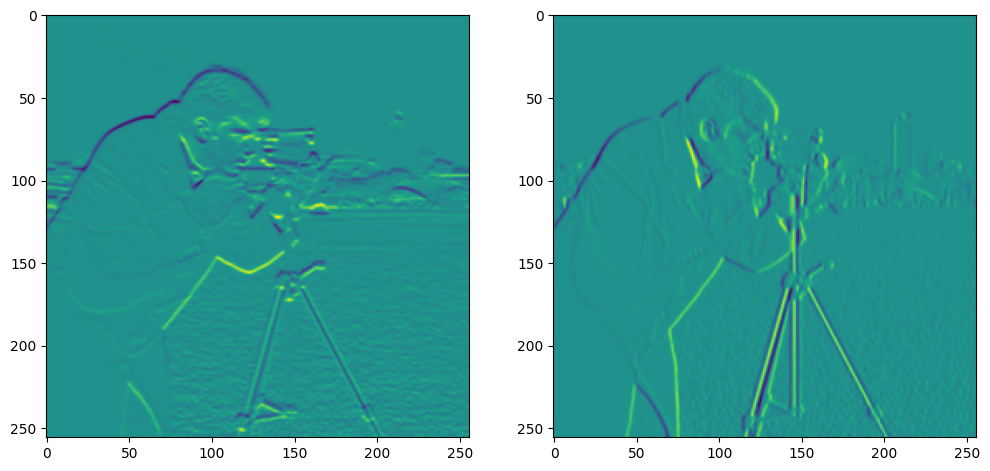

In [16]:
img = get_cameraman_tensor(256)

grads_x = scipy.ndimage.sobel(img.numpy(), axis=1).squeeze(0)[..., None]
grads_y = scipy.ndimage.sobel(img.numpy(), axis=2).squeeze(0)[..., None]
grads_x, grads_y = torch.from_numpy(grads_x), torch.from_numpy(grads_y)

fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].imshow(grads_x)
axes[1].imshow(grads_y)
plt.show()

#### Instantiate a dataset and a SIREN model

In [17]:
cameraman_poisson = PoissonEqn(128)
dataloader = DataLoader(cameraman_poisson, batch_size=1, pin_memory=True, num_workers=0)

poisson_siren = Siren(in_features=2, out_features=1, hidden_features=256,
                      hidden_layers=3, outermost_linear=True)
poisson_siren.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

#### Train the model

In [18]:
total_steps = 1000
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-4, params=poisson_siren.parameters())

model_input, gt = next(iter(dataloader))
gt = {key: value.cuda() for key, value in gt.items()}
model_input = model_input.cuda()

for step in range(total_steps):
    start_time = time.time()

    model_output, coords = poisson_siren(model_input)
    train_loss = gradients_mse(model_output, coords, gt['grads'])

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f, iteration time %0.6f" % (step, train_loss, time.time() - start_time))

        img_grad = gradient(model_output, coords)
        img_laplacian = laplace(model_output, coords)

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        axes[0].imshow(model_output.cpu().view(128,128).detach().numpy())
        axes[1].imshow(img_grad.cpu().norm(dim=-1).view(128,128).detach().numpy())
        axes[2].imshow(img_laplacian.cpu().view(128,128).detach().numpy())
        plt.show()

    optim.zero_grad()
    train_loss.backward()
    optim.step()

Output hidden; open in https://colab.research.google.com to view.

#### out-of-range behavior
out-of-range 도메인에서 SIREN은 어떻게 학습되었을까요? 아래 코드는 학습 도메인인 [-1, +1] 범위가 아닌 [-50, +50] 범위에서 샘플링된 SIREN의 결과값을 보여줍니다.


In [19]:
with torch.no_grad():
    out_of_range_coords = get_mgrid(1024, 2) * 50
    model_out, _ = poisson_siren(out_of_range_coords.cuda())

    fig, ax = plt.subplots(figsize=(16,16))
    ax.imshow(model_out.cpu().view(1024,1024).numpy())
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Quiz 2: Zoom in
- 입력 도메인에서 특정 부분만을 집중적으로 샘플링하여 이미지를 완성하세요.
- [-0.5, -0.5] ~ [0.5, 0.5]의 범위에서 size=128의 grid를 샘플링하여 이미지를 완성하세요.
- [-0.5, -0.5] ~ [0.5, 0.5]의 범위에서 size=1024의 grid를 샘플링하여 이미지를 완성하세요.

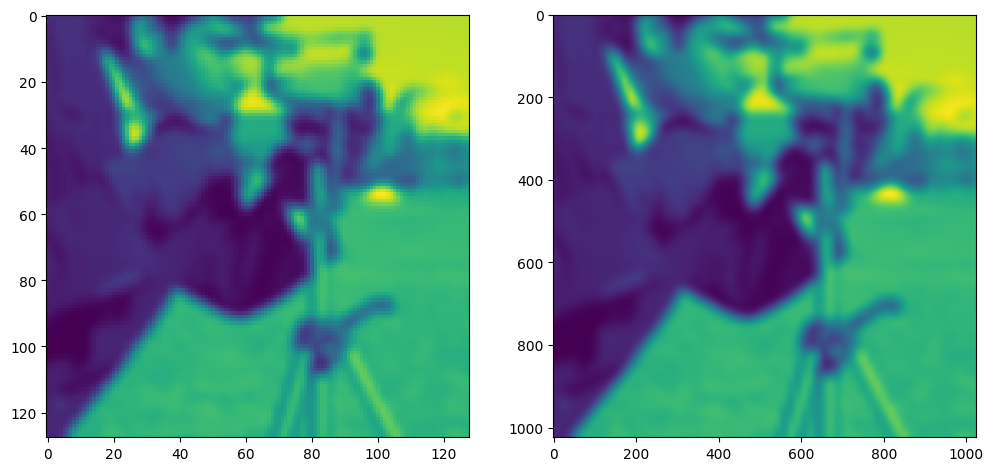

In [21]:
with torch.no_grad():
  # 입력 도메인의 특정 부분만을 집중 샘플링
  # 그 전 샘플링 참고

    ######## Implement from here ########
    model_out_128, _ = poisson_siren((get_mgrid(128, 2) / 2).cuda())
    model_out_1024, _ = poisson_siren((get_mgrid(1024, 2) / 2).cuda())
    ####### End of Implementation #######

    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    ax[0].imshow(model_out_128.cpu().view(128,128).numpy())
    ax[1].imshow(model_out_1024.cpu().view(1024,1024).numpy())
    plt.show()

### Quiz 3: Possion Image Editing

## 3. Fitting SDF from Point Clouds


본 섹션에서는 point cloud가 주어졌을 때 이로부터 3차원 surface를 복원하는 방법에 대해 다룹니다.
3차원 surface는 Signed Distance Field (SDF) $\Phi: x \rightarrow s$로 표현됩니다. 이 때, $x$는 3차원 좌표, $s$는 surface까지의 거리를 의미합니다.

이를 위해 다음의 손실함수 $\mathcal{L}$로 $\Phi$를 최적화합니다:
$$\mathcal{L}=\int_{\Omega} \lVert |\nabla\Phi(x)| - 1 \rVert\mathrm{d}\mathbf{x} + \int_{\Omega_0}\lVert\Phi(x)\rVert + (1-\nabla\Phi(x) \cdot n(x))\mathrm{d}\mathbf{x} + \int_{\Omega\setminus\Omega_0} \Psi(\Phi(x))\mathrm{d}\mathbf{x}$$

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
%cd /content/drive/MyDrive/ai_expert/24_siren/

/content/drive/MyDrive/ai_expert/24_siren


In [10]:
%ls

08_21.ipynb  thai_statue.xyz  원본/


#### Define the loss function

In [11]:
def sdf_loss(pred_sdf, coords, gt_sdf, gt_normals):
    '''
       x: batch of input coordinates
       y: usually the output of the trial_soln function
       '''

    _gradient = gradient(pred_sdf, coords)

    # Wherever boundary_values is not equal to zero, we interpret it as a boundary constraint.
    sdf_constraint = torch.where(gt_sdf != -1, pred_sdf, torch.zeros_like(pred_sdf))
    inter_constraint = torch.where(gt_sdf != -1, torch.zeros_like(pred_sdf), torch.exp(-1e2 * torch.abs(pred_sdf)))
    normal_constraint = torch.where(gt_sdf != -1, 1 - F.cosine_similarity(_gradient, gt_normals, dim=-1)[..., None],
                                    torch.zeros_like(_gradient[..., :1]))
    grad_constraint = torch.abs(_gradient.norm(dim=-1) - 1)
    return {'sdf': torch.abs(sdf_constraint).mean() * 3e3,
            'inter': inter_constraint.mean() * 1e2,
            'normal_constraint': normal_constraint.mean() * 1e2,
            'grad_constraint': grad_constraint.mean() * 5e1}

#### Define Pytorch Dataset

* 데이터셋으로는 3D Stanford Model의 Thai Statue를 사용합니다. ([download link](https://drive.google.com/drive/folders/1_iq__37-hw7FJOEUK1tX7mdp8SKB368K))
* 'thai_statue.xyz'를 다운로드 받은 후, 이를 colab의 가장 상위 폴더에 저장해주세요.
* xyz file의 visualization은 MeshLab([link](https://www.meshlab.net/))을 통해 가능합니다.
* 아래의 데이터셋은 입력 point cloud로부터 on_surface_points만큼의 포인트를 샘플링하고, 전체 도메인으로부터 같은 개수의 포인트를 샘플링하여, 해당 포인트의 SDF와 Normal값을 함께 return합니다.

In [12]:
class PointCloud(Dataset):
    def __init__(self, on_surface_points, keep_aspect_ratio=True):
        super().__init__()

        print("Loading point cloud")
        point_cloud = np.genfromtxt('./thai_statue.xyz')
        print("Finished loading point cloud")

        coords = point_cloud[:, :3]
        self.normals = point_cloud[:, 3:]

        # Reshape point cloud such that it lies in bounding box of (-1, 1) (distorts geometry, but makes for high
        # sample efficiency)
        coords -= np.mean(coords, axis=0, keepdims=True)
        if keep_aspect_ratio:
            coord_max = np.amax(coords)
            coord_min = np.amin(coords)
        else:
            coord_max = np.amax(coords, axis=0, keepdims=True)
            coord_min = np.amin(coords, axis=0, keepdims=True)

        self.coords = (coords - coord_min) / (coord_max - coord_min)
        self.coords -= 0.5
        self.coords *= 2.

        self.on_surface_points = on_surface_points

    def __len__(self):
        return self.coords.shape[0] // self.on_surface_points

    def __getitem__(self, idx):
        point_cloud_size = self.coords.shape[0]

        off_surface_samples = self.on_surface_points  # **2
        total_samples = self.on_surface_points + off_surface_samples

        # Random coords
        rand_idcs = np.random.choice(point_cloud_size, size=self.on_surface_points)

        on_surface_coords = self.coords[rand_idcs, :]
        on_surface_normals = self.normals[rand_idcs, :]

        off_surface_coords = np.random.uniform(-1, 1, size=(off_surface_samples, 3))
        off_surface_normals = np.ones((off_surface_samples, 3)) * -1

        sdf = np.zeros((total_samples, 1))  # on-surface = 0
        sdf[self.on_surface_points:, :] = -1  # off-surface = -1

        coords = np.concatenate((on_surface_coords, off_surface_coords), axis=0)
        normals = np.concatenate((on_surface_normals, off_surface_normals), axis=0)

        return {'coords': torch.from_numpy(coords).float()}, {'sdf': torch.from_numpy(sdf).float(),
                                                              'normals': torch.from_numpy(normals).float()}

#### Instantiate a dataset and a SIREN model

In [15]:
thai_statue = PointCloud(250000)
dataloader = DataLoader(thai_statue, batch_size=1, pin_memory=True, num_workers=0)

sdf_siren = Siren(in_features=3, out_features=1, hidden_features=256,
                  hidden_layers=3, outermost_linear=True)
sdf_siren.cuda()

Loading point cloud
Finished loading point cloud


Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=3, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

#### Train the model

In [20]:
### Training loop
total_steps = 2000
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-4, params=sdf_siren.parameters())


for step in range(total_steps):
    model_input, ground_truth = next(iter(dataloader))
    model_input, sdf_gt, normals_gt = model_input['coords'].cuda(), ground_truth['sdf'].cuda(), ground_truth['normals'].cuda()
    sdf_pred, coords = sdf_siren(model_input)
    losses = sdf_loss(sdf_pred, coords, sdf_gt, normals_gt)
    train_loss = 0
    log_message = "Step %d, " % step
    for loss_name, loss in losses.items():
        single_loss = loss.mean()
        train_loss += single_loss
        log_message += ("%s %0.2f, " % (loss_name, single_loss.item()))

    if not step % steps_til_summary:
        #print("Step %d, Total loss %0.6f" % (step, train_loss))
        log_message += "Total loss %0.6f" % (train_loss)
        print(log_message)

    optim.zero_grad()
    train_loss.backward()
    optim.step()

Step 0, sdf 40.52, inter 7.59, normal_constraint 49.47, grad_constraint 34.29, Total loss 131.877899


OutOfMemoryError: ignored

#### Extract a mesh from a SDF

In [ ]:
import logging
import plyfile
import skimage.measure


def create_mesh(
    decoder, filename, N=256, max_batch=64 ** 3, offset=None, scale=None
):
    start = time.time()
    ply_filename = filename

    decoder.eval()

    # NOTE: the voxel_origin is actually the (bottom, left, down) corner, not the middle
    voxel_origin = [-1, -1, -1]
    voxel_size = 2.0 / (N - 1)

    overall_index = torch.arange(0, N ** 3, 1, out=torch.LongTensor())
    samples = torch.zeros(N ** 3, 4)

    # transform first 3 columns
    # to be the x, y, z index
    samples[:, 2] = overall_index % N
    samples[:, 1] = (overall_index.long() / N) % N
    samples[:, 0] = ((overall_index.long() / N) / N) % N

    # transform first 3 columns
    # to be the x, y, z coordinate
    samples[:, 0] = (samples[:, 0] * voxel_size) + voxel_origin[2]
    samples[:, 1] = (samples[:, 1] * voxel_size) + voxel_origin[1]
    samples[:, 2] = (samples[:, 2] * voxel_size) + voxel_origin[0]

    num_samples = N ** 3

    samples.requires_grad = False

    head = 0

    while head < num_samples:
        print(head)
        sample_subset = samples[head : min(head + max_batch, num_samples), 0:3].cuda()

        samples[head : min(head + max_batch, num_samples), 3] = (
            decoder(sample_subset)[0]
            .squeeze()#.squeeze(1)
            .detach()
            .cpu()
        )
        head += max_batch

    sdf_values = samples[:, 3]
    sdf_values = sdf_values.reshape(N, N, N)

    end = time.time()
    print("sampling takes: %f" % (end - start))

    convert_sdf_samples_to_ply(
        sdf_values.data.cpu(),
        voxel_origin,
        voxel_size,
        ply_filename + ".ply",
        offset,
        scale,
    )


def convert_sdf_samples_to_ply(
    pytorch_3d_sdf_tensor,
    voxel_grid_origin,
    voxel_size,
    ply_filename_out,
    offset=None,
    scale=None,
):
    """
    Convert sdf samples to .ply

    :param pytorch_3d_sdf_tensor: a torch.FloatTensor of shape (n,n,n)
    :voxel_grid_origin: a list of three floats: the bottom, left, down origin of the voxel grid
    :voxel_size: float, the size of the voxels
    :ply_filename_out: string, path of the filename to save to

    This function adapted from: https://github.com/RobotLocomotion/spartan
    """

    start_time = time.time()

    numpy_3d_sdf_tensor = pytorch_3d_sdf_tensor.numpy()

    verts, faces, normals, values = np.zeros((0, 3)), np.zeros((0, 3)), np.zeros((0, 3)), np.zeros(0)
    verts, faces, normals, values = skimage.measure.marching_cubes(
        numpy_3d_sdf_tensor, level=0.0, spacing=[voxel_size] * 3
    )

    # transform from voxel coordinates to camera coordinates
    # note x and y are flipped in the output of marching_cubes
    mesh_points = np.zeros_like(verts)
    mesh_points[:, 0] = voxel_grid_origin[0] + verts[:, 0]
    mesh_points[:, 1] = voxel_grid_origin[1] + verts[:, 1]
    mesh_points[:, 2] = voxel_grid_origin[2] + verts[:, 2]

    # apply additional offset and scale
    if scale is not None:
        mesh_points = mesh_points / scale
    if offset is not None:
        mesh_points = mesh_points - offset

    # try writing to the ply file

    num_verts = verts.shape[0]
    num_faces = faces.shape[0]

    verts_tuple = np.zeros((num_verts,), dtype=[("x", "f4"), ("y", "f4"), ("z", "f4")])

    for i in range(0, num_verts):
        verts_tuple[i] = tuple(mesh_points[i, :])

    faces_building = []
    for i in range(0, num_faces):
        faces_building.append(((faces[i, :].tolist(),)))
    faces_tuple = np.array(faces_building, dtype=[("vertex_indices", "i4", (3,))])

    el_verts = plyfile.PlyElement.describe(verts_tuple, "vertex")
    el_faces = plyfile.PlyElement.describe(faces_tuple, "face")

    ply_data = plyfile.PlyData([el_verts, el_faces])
    logging.debug("saving mesh to %s" % (ply_filename_out))
    ply_data.write(ply_filename_out)

    logging.debug(
        "converting to ply format and writing to file took {} s".format(
            time.time() - start_time
        )
    )

학습된 SDF로부터 mesh를 추출하고 이를 result.ply로 저장합니다. 이를 로컬컴퓨터로 다운받아 meshlab으로 visualize할 수 있습니다.

In [ ]:
create_mesh(sdf_siren, './result')

### Quiz 3: Fitting SDF without supervision of normal
* Normal에 대한 supervision 없이 SDF를 fitting할 수 있을지 예측해보세요.
* Normal에 대한 supervision 없이 SIREN을 학습하고 결과값을 비교해보세요.